In [1]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2023/05/30
 
@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
"""
###########################################################################
# Seminar on Quantum Technologies for Cybersecurity: Networking and Systems
# Class
# Session 2 - Quantum implementation aspects

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:  
  import qiskit
except:
  print("installing qiskit...")
  !pip install qiskit --quiet
  print("installed qiskit.")
  import qiskit


installing qiskit...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.3 MB/s eta 0:00:00
installed qiskit.


# Measurement in the different basis

{'10': 521, '01': 503}


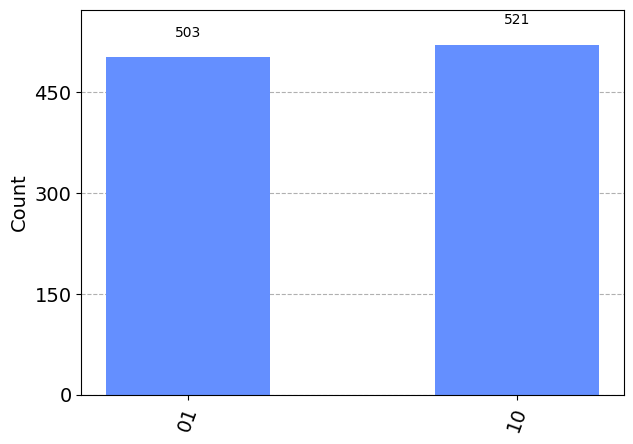

In [105]:
#########################################################
# Measurement of states and mixturesin different basis
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
# https://arxiv.org/pdf/1804.03719.pdf: Quantum Algorithm Implementations for Beginners
NumberShots=1024

QubitMode='StateVector'#'StateVector'#'DensityMatrix'
MeasurementBasis='Y'#'Z': computational,'X': diagonal, 'Y': circular
UseBellState=True

qr=QuantumRegister(2,'q')
cr=ClassicalRegister(2,'c')
qc=QuantumCircuit(qr,cr)

if (QubitMode=='DensityMatrix'):
  if (UseBellState):
    RhoState = DensityMatrix([[0.25,0.0,0.0,0.25],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.25,0.0,0.0,0.25]]) # In the computational base. Bell state
  else:
    RhoState = DensityMatrix([[1.0/2.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,1.0/2.0]]) # In the computational base. Bipartite correlated state  
  display(plot_state_city(RhoState,title='Initial'))
else:
  if (UseBellState):
    state = Statevector([1.0/np.sqrt(2),0.0,0.0,1.0/np.sqrt(2)]) # In the computational base. Bell state
  else:
    state = Statevector([1.0/np.sqrt(2),1.0/np.sqrt(2),0.0,0.0]) # In the computational base. Non Bell state
  
  qc.initialize(state.data, [0,1]) # Initialize both qubits at the same time

# https://quantumcomputing.stackexchange.com/questions/13605/how-to-measure-in-another-basis
if (MeasurementBasis=='X'): # diagonal
  # Measure both qubits and store the result in the classical bits  
  qc.h(qr[0])
  qc.h(qr[1])
  if (QubitMode=='DensityMatrix'):
    RhoStateEvolved=RhoState.evolve(qc)
  else:
    qc.measure(qr,cr)
elif(MeasurementBasis=='Y'): # circular
  # Measure both qubits and store the result in the classical bits
  qc.sdg(qr[0])
  qc.h(qr[0])
  qc.sdg(qr[1])
  qc.h(qr[1])
  if (QubitMode=='DensityMatrix'):
    RhoStateEvolved=RhoState.evolve(qc)
  else:
    qc.measure(qr,cr)
else: #'Z' Computational
  # Measure both qubits and store the result in the classical bits  
  if (QubitMode=='DensityMatrix'):
    RhoStateEvolved=RhoState.evolve(qc)
  else:
    qc.measure(qr,cr)

if (QubitMode=='DensityMatrix'):
  #print(RhoStateEvolved)
  display(plot_state_city(RhoStateEvolved,title='Evolved'))
  #print(np.sum(RhoStateEvolved.data,axis=0))
  StatesProb=np.sum(np.real(RhoStateEvolved.data),axis=0)
  counts={'00':NumberShots*StatesProb[0],'01':NumberShots*StatesProb[1],'10':NumberShots*StatesProb[2],'11':NumberShots*StatesProb[3]}
  display(plot_histogram(counts))
else:
  backend=Aer.get_backend('qasm_simulator')
  job=execute(qc,backend,shots=NumberShots)
  result=job.result()
  # Print the results
  counts=result.get_counts(qc)
  print(counts)
  display(plot_histogram(counts))


# Entanglement

|00> state entanglement: 0.00


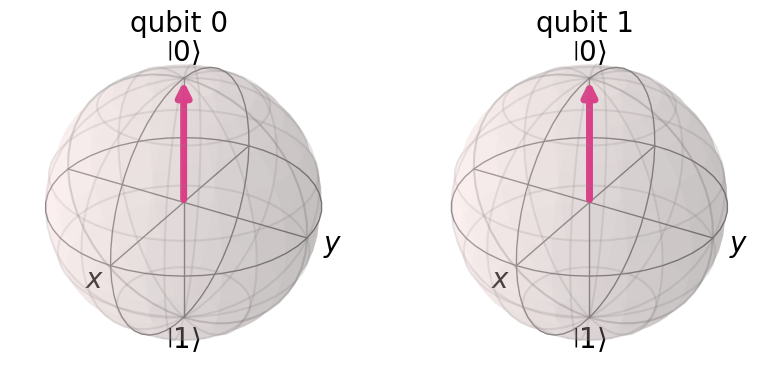

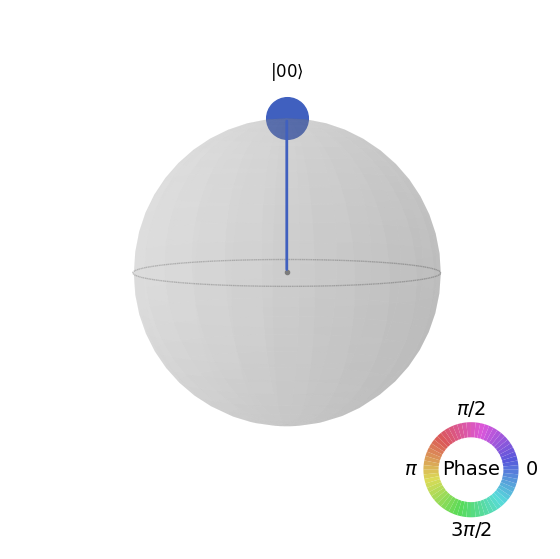

In [2]:
######################################################################
# Check the amount of entanglement
from qiskit.quantum_info import entanglement_of_formation
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere
import numpy as np
li = np.sqrt(0.5) #shortcut for 1/sqrt(2)

#|00> state:
just00 = [1, 0, 0, 0] 
print(f'|00> state entanglement: {entanglement_of_formation(just00):.2f}')
display(plot_bloch_multivector(just00))
#returns 0.0
display(plot_state_qsphere(just00))

Bell state entanglement: 1.00


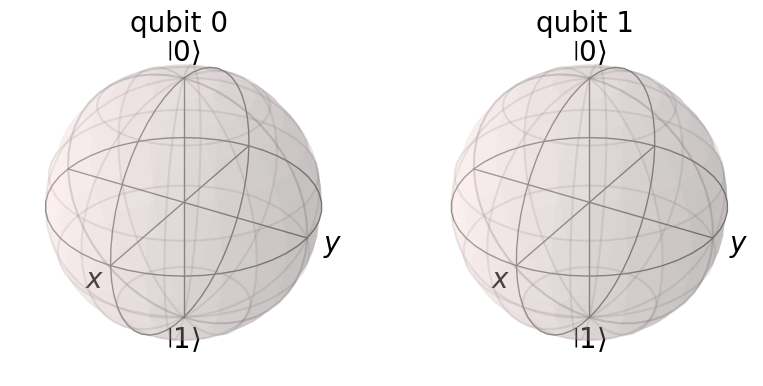

In [16]:
#Bell state:
bell = [li, 0, 0, li]
print(f'Bell state entanglement: {entanglement_of_formation(bell):.2f}')
display(plot_bloch_multivector(bell))
#returns 0.9999999999999999 (practically 1...)
display(plot_state_qsphere(bell))

|+0> state entanglement: 1.60e-16


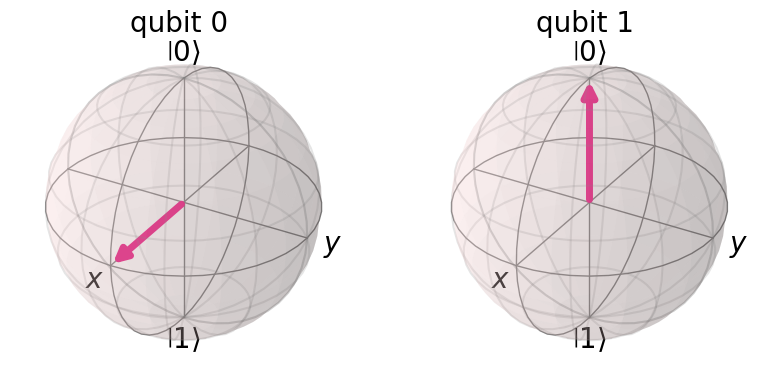

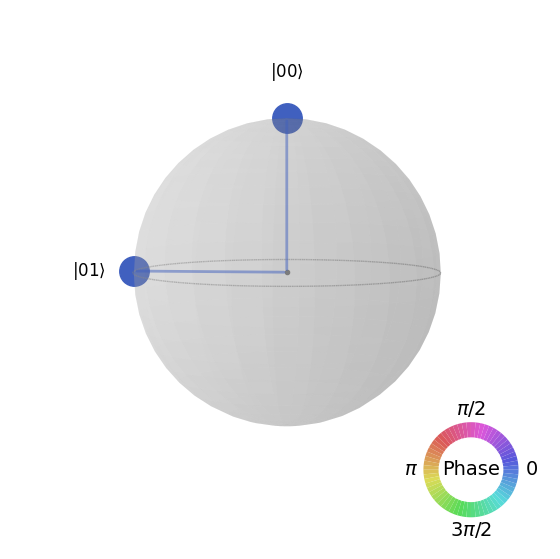

In [25]:
#Not really Bell (|+0>):
plus0 = [li, li, 0, 0]
print(f'|+0> state entanglement: {entanglement_of_formation(plus0):.2e}')
display(plot_bloch_multivector(plus0))
#returns 1.6017132519074586e-16 (practically zero...)
display(plot_state_qsphere(plus0))

State vector: [0.4080999 -0.07526827j 0.03245512+0.03314565j 0.04902795+0.02624031j
 0.2478993 +0.07872094j]
{'11': 775, '01': 236, '00': 797, '10': 240}


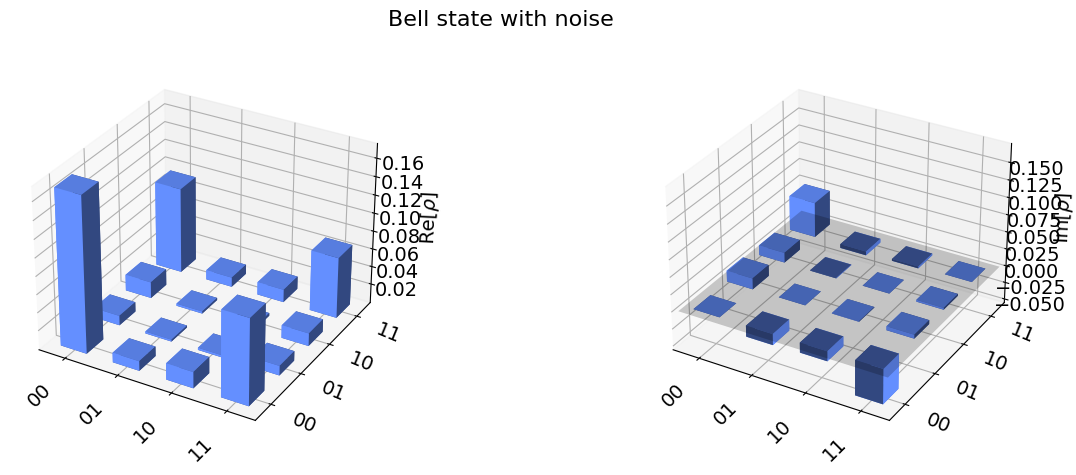

In [ ]:
######################################################################
# Entanglement circuit with or without noise
NoiseFlag=True # Activate or desactivate noise
NumberShots=int(2048)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile
from qiskit.visualization import plot_histogram,plot_state_city
import qiskit_aer.noise as noise

# Create a quantum circuit with 2 qubits and 2 clasical bits
qr=QuantumRegister(2,'q')
cr=ClassicalRegister(2,'c')
qc1=QuantumCircuit(qr,cr)

# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])

# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
#print(qc1)
qc1.save_statevector(label='v1', pershot = True)
# Measure both qubits and store the result in the classical bits
qc1.measure(qr,cr)

# Error probabilities
prob_1 = 0.5  # 1-qubit gate
prob_2 = 0.5   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#print(noise_model)

# Run the circuit on a simulator
backend=Aer.get_backend('qasm_simulator')
sv1aux = np.zeros((4),dtype=np.complex64)
if (NoiseFlag):
  job=execute(qc1,backend,noise_model=noise_model,shots=NumberShots)
  result=job.result()
  for iIterStateVector in range(0,NumberShots,1):
    sv1aux += np.asarray([result.data(0)['v1'][iIterStateVector][0],result.data(0)['v1'][iIterStateVector][1],result.data(0)['v1'][iIterStateVector][2],result.data(0)['v1'][iIterStateVector][3]]) # state vector
  sv1=sv1aux/float(NumberShots)
else:
  job=execute(qc1,backend,shots=NumberShots)#
  result=job.result()
  sv1 = [result.data(0)['v1'][0][0],result.data(0)['v1'][0][1],result.data(0)['v1'][0][2],result.data(0)['v1'][0][3]] # state vector#sv1=result.data(0)['v1']

print(f'State vector: {sv1}')

# Print the results
counts=result.get_counts(qc1)
print(counts)
display(plot_histogram(counts))

if (NoiseFlag):
  plotstring='Bell state with noise'
else:
  plotstring='Bell state'
display(plot_state_city(sv1, title=plotstring))

In [ ]:
###########################################################################
# Fidelity
# set up qc1 and qc2
import qiskit_aer.noise as noise
from qiskit.quantum_info import state_fidelity
qc1=QuantumCircuit(qr)
# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])
# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
qc1.save_statevector(label='v1', pershot = True)

# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
#print(bell)

# Error probabilities
prob_1 = 0.1  # 1-qubit gate
prob_2 = 0.1   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
#print(noise_model)

backend1=Aer.get_backend('qasm_simulator')
backend2 = Aer.get_backend('statevector_simulator')

sv2 = execute(bell, backend2,shots=NumberShots).result().get_statevector(bell)

AvgStateFidelity=0.0
if (NoiseFlag):
  job=execute(qc1,backend1,noise_model=noise_model,shots=NumberShots)
  result=job.result()
  for iIter in range(0,NumberShots,1):
    sv1 = result.data(0)['v1'][iIter]
    AvgStateFidelity+=state_fidelity(sv1, sv2)
  AvgStateFidelity=AvgStateFidelity/float(NumberShots)
else:
  job=execute(qc1,backend1,shots=NumberShots)
  result=job.result()
  sv1 = result.data(0)['v1'][0]
  AvgStateFidelity=state_fidelity(sv1, sv2)

print(f'Average fidelity: {AvgStateFidelity:.2f}')

Average fidelity: 0.88


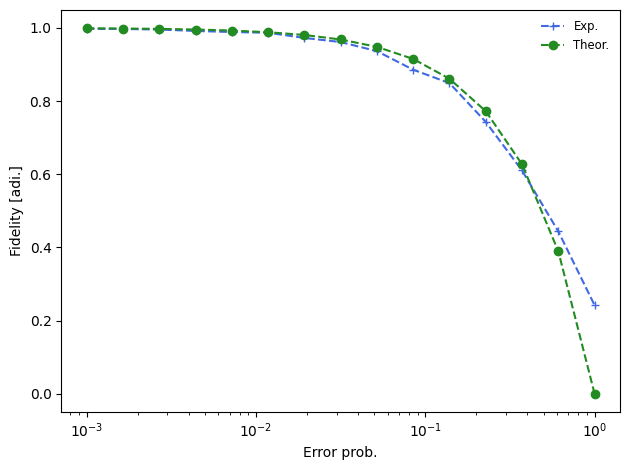

In [ ]:
###########################################################################
# Fidelity dependence with error probability
# set up qc1 and qc2
import qiskit_aer.noise as noise
from qiskit.quantum_info import state_fidelity
qc1=QuantumCircuit(qr)
# Apply a Hadamard gate to the first qubit
qc1.h(qr[0])
# Apply a CNOT gate between the first and second qubits
qc1.cx(qr[0],qr[1])
qc1.save_statevector(label='v1', pershot = True)

# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
#print(bell)

backend1=Aer.get_backend('qasm_simulator')
backend2 = Aer.get_backend('statevector_simulator')

sv2 = execute(bell, backend2,shots=NumberShots).result().get_statevector(bell)

NcalcErrorProb=15
ErrorProbScan=np.logspace(-3,0,NcalcErrorProb)
AvgStateFidelityScan=np.zeros((NcalcErrorProb),dtype=np.float32)
TheorStateFidelityScan=np.zeros((NcalcErrorProb),dtype=np.float32)
for iIterScan in range(0,NcalcErrorProb,1):
  # Error probabilities
  prob_1 = ErrorProbScan[iIterScan]  # 1-qubit gate
  prob_2 = ErrorProbScan[iIterScan]  # 2-qubit gate

  # Depolarizing quantum errors
  error_1 = noise.depolarizing_error(prob_1, 1)
  error_2 = noise.depolarizing_error(prob_2, 2)

  # Add errors to noise model
  noise_model = noise.NoiseModel()
  noise_model.add_all_qubit_quantum_error(error_1, ['h','rz', 'sx', 'x'])
  noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
  #print(noise_model)

  if (NoiseFlag):
    job=execute(qc1,backend1,noise_model=noise_model,shots=NumberShots)
    result=job.result()
    for iIter in range(0,NumberShots,1):
      sv1 = result.data(0)['v1'][iIter]
      AvgStateFidelityScan[iIterScan]+=state_fidelity(sv1, sv2)
    AvgStateFidelityScan[iIterScan]=AvgStateFidelityScan[iIterScan]/float(NumberShots)
  else:
    job=execute(qc1,backend1,shots=NumberShots)
    result=job.result()
    sv1 = result.data(0)['v1'][0]
    AvgStateFidelityScan[iIterScan]=state_fidelity(sv1, sv2)
  
  TheorStateFidelityScan[iIterScan]=(1.0-ErrorProbScan[iIterScan])

plt.figure()
line1,=plt.plot(ErrorProbScan,AvgStateFidelityScan,'royalblue',linestyle='dashed',marker='+')
line2,=plt.plot(ErrorProbScan,TheorStateFidelityScan,'forestgreen',linestyle='dashed',marker='o')
#plt.xlim(np.max([Time1[0],Time2[0]]),np.min([Time1[-1],Time2[-1]]))
plt.xlabel('Error prob.',color='k')
plt.ylabel('Fidelity [adi.]',color='k')
plt.xscale('log')
plt.legend((line1,line2), ('Exp.','Theor.'),loc="best",shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.tight_layout()
plt.show()